# 初期設定、ライブラリインポート

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install japanize_matplotlib
!pip install optuna
import japanize_matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import optuna.integration.lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
STUDY_EDA = False
DEBUG = False

input_path = '/content/drive/MyDrive/input/signate_car_distance/'
output_path = '/content/drive/MyDrive/output/signate_car_distance/'
interm_path = '/content/drive/MyDrive/intermediate/signate_car_distance/'
now = dt.datetime.today()
month = str(now.month)
day = str(now.day)
comment = 'car_distance_prediction'

save_nm = f'submission_{comment}_{month}_{day}.csv'
print(save_nm)

submission_car_distance_prediction_5_17.csv


In [4]:
train_df = pd.read_csv(input_path + 'train.csv')
test_df = pd.read_csv(input_path + 'test.csv')
sample_submission_df = pd.read_csv(input_path + 'sample_submit.csv', header = None)

In [5]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
train_test = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)

# EDA

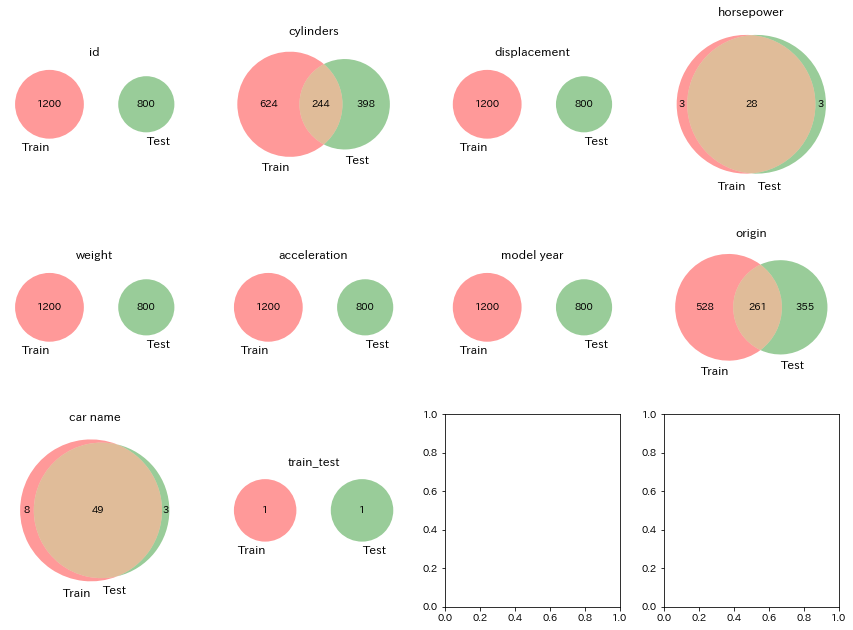

In [6]:
from matplotlib_venn import venn2
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [7]:
print(train_test.shape)
train_test.head(3)

(2000, 11)


,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,train_test
0,0,8.002,308.763915,140,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401,train
1,1,8.002,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679,train
2,2,4.002,95.382697,70,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575,train


In [8]:
print(train_test.isnull().sum())

id                0
cylinders         0
displacement      0
horsepower        0
weight            0
acceleration      0
model year        0
origin            0
car name          0
mpg             800
train_test        0
dtype: int64


In [9]:
print(train_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2000 non-null   int64  
 1   cylinders     2000 non-null   float64
 2   displacement  2000 non-null   float64
 3   horsepower    2000 non-null   object 
 4   weight        2000 non-null   float64
 5   acceleration  2000 non-null   float64
 6   model year    2000 non-null   float64
 7   origin        2000 non-null   float64
 8   car name      2000 non-null   object 
 9   mpg           1200 non-null   float64
 10  train_test    2000 non-null   object 
dtypes: float64(7), int64(1), object(3)
memory usage: 172.0+ KB
None


In [10]:
for col_nm in train_test.columns:
    print(col_nm)
    print(train_test[col_nm].nunique())
    print(train_test[col_nm].unique())

    print('*'*80)
    print('*'*80)
    print('*'*80)

id
2000
[   0    1    2 ... 1997 1998 1999]
********************************************************************************
********************************************************************************
********************************************************************************
cylinders
1266
[8.00199994 8.00199992 4.00199983 ... 6.00199976 4.00199897 4.00199997]
********************************************************************************
********************************************************************************
********************************************************************************
displacement
2000
[308.7639152 421.5573791  95.3826971 ... 225.1894008 307.6514483
 147.0325536]
********************************************************************************
********************************************************************************
********************************************************************************
horsepower
34
['140' '220' '70' '85' '150' 

## dtype修正

In [11]:
train_test['model year'] = train_test['model year'].astype(float)
train_test['origin'] = train_test['origin'].astype(float)

In [12]:
len(train_test[train_test['horsepower'] == '?'])
tmp_train_test = train_test[train_test['horsepower'] != '?']
horsepower_mean = tmp_train_test['horsepower'].astype(float).mean()
print(horsepower_mean)

106.88107549120993


In [13]:
train_test['horsepower'] = train_test['horsepower'].apply(lambda x:str(int(np.round(horsepower_mean))) if x == '?' else x)
train_test['horsepower'].unique()

array(['140', '220', '70', '85', '150', '97', '112', '60', '100', '120',
       '107', '139', '90', '108', '122', '148', '71', '72', '69', '110',
       '67', '130', '95', '145', '132', '75', '193', '54', '78', '61',
       '64', '165', '58', '135'], dtype=object)

In [14]:
train_test['horsepower'] = train_test['horsepower'].astype(int)

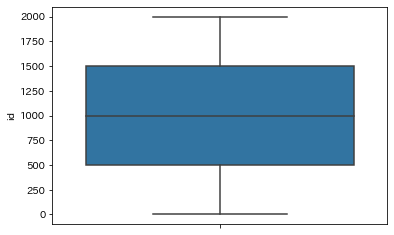

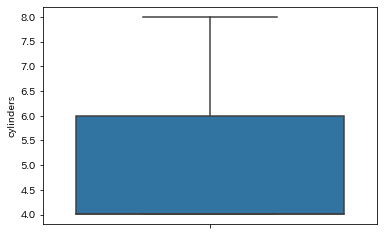

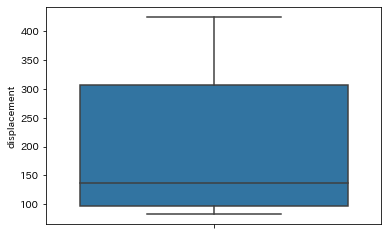

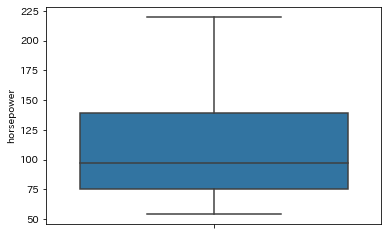

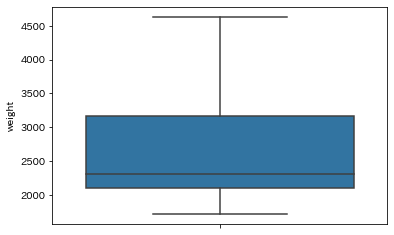

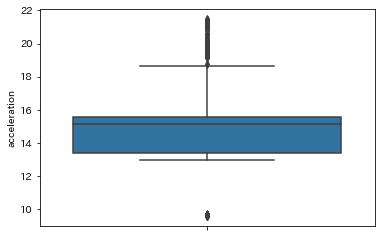

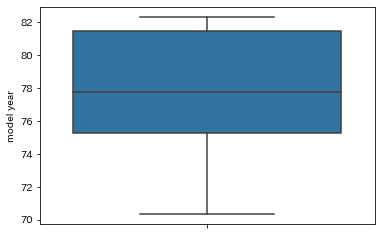

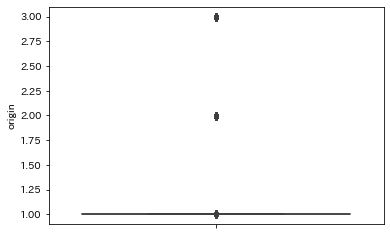

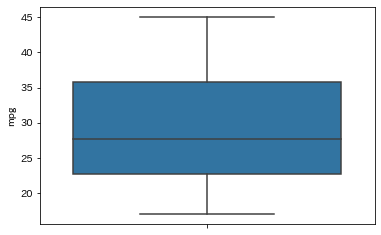

In [15]:
for col_nm in train_test.columns:

    if train_test[col_nm].dtype != 'object':

        sns.boxplot(y = col_nm, data = train_test)
        plt.show()

        print()
        print()

In [16]:
# print(len(train_test[train_test['acceleration'] <= 10]))
# train_test[train_test['acceleration'] <= 10].head()

In [17]:
# print(len(train_test[train_test['origin'] >= 1.5]))
# train_test[train_test['origin'] >= 1.5].head()

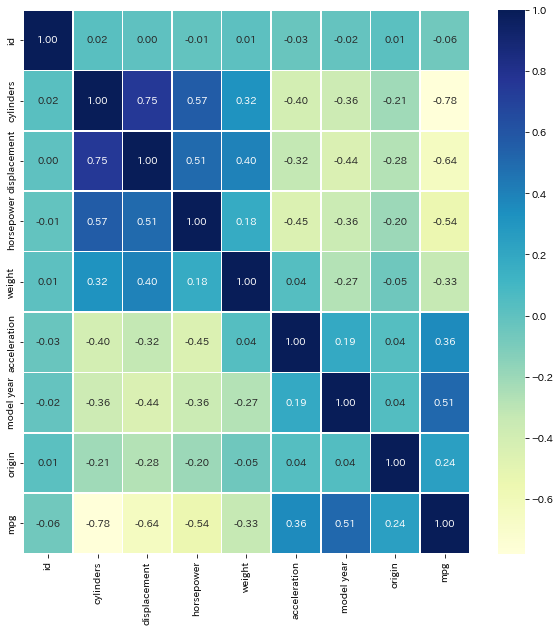

In [18]:
plt.figure(figsize = (10, 10))
sns.heatmap(train_test.corr(), fmt="1.2f", annot=True, lw=0.7, cmap='YlGnBu')

# 前処理

## company_name

In [19]:
def company_standlize(x):

    """
    company_nameの表記ゆれを直す

    Args:
        x(str):company_name
   
    Returns:
        x(str):company_nameの表記ゆれ直した後
        
    """ 


    if x == 'toyouta':
        return 'toyota'
    
    elif x == 'volkswagen':
        return 'vw'

    elif x == 'capri':
        return 'ford'

    elif x == 'mercury':
        return 'ford'

    elif x == 'datsun':
        return 'nissan'

    elif x == 'pontiac':
        return 'gm'
    
    elif x == 'buick':
        return 'gm'

    elif x == 'plymouth':
        return 'chrysler'

    else:
        return x

In [20]:
train_test['company_name'] = train_test['car name'].apply(lambda x:x.split(' ')[0])
train_test['company_name'] = train_test['company_name'].apply(company_standlize)
train_test['company_name'].unique()

array(['ford', 'nissan', 'peugeot', 'triumph', 'gm', 'saab', 'toyota',
       'chevrolet', 'dodge', 'honda', 'vw', 'audi', 'chrysler', 'opel',
       'amc', 'hi', 'fiat', 'oldsmobile', 'renault'], dtype=object)

## describe

In [21]:
def grouping_describe(df, key_describe_cols, stat_describe_cols, agg_describe_kinds):
      
    """
    統計値を取得する

    Args:
        df(DataFrame):前処理するデータ
        agg_describe_kinds(リスト):統計リスト
        
    Returns:
        df(DataFrame)
        
    """  
        
    for key_col, agg_kind, stat_col in itertools.product(key_describe_cols, agg_describe_kinds, stat_describe_cols):
        
        df['group_by_' + key_col + 'stat_' + stat_col + '_' + agg_kind] = df.groupby([key_col])[stat_col].transform(agg_kind)

        
        if agg_kind in ['max', 'mean', 'min']:
            
            df['group_by_' + key_col + 'diff_' + stat_col + '_' + agg_kind] = df['group_by_' + key_col + 'stat_' + stat_col + '_' + agg_kind] - df[stat_col]

        
    return df

In [22]:
print('***********************************************************************************')
print('preprocessing...grouping_describe')
# breath_idごとに統計値を算出する
# df.groupby(['breath_id'])[stat_col].transform(agg_kind)

key_describe_cols = [
    'car name',
    'company_name'
]

stat_describe_cols = [
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model year',
    'origin'
]

agg_describe_kinds = [
    'count', 
    'mean', 
    'min', 
    'max',
    'nunique',
    'std' 
]

train_test = grouping_describe(train_test, key_describe_cols, stat_describe_cols, agg_describe_kinds)

print('finished')
print('***********************************************************************************')

***********************************************************************************
preprocessing...grouping_describe
finished
***********************************************************************************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


## label encoding

In [23]:
label_cols = [
    'car name',
    'company_name'
]

for label_col in label_cols:
    le = LabelEncoder()
    train_test[label_col] = train_test[label_col].fillna(train_test[label_col].mode()[0])
    train_test[label_col] = le.fit_transform(train_test[label_col])

# 予測

In [24]:
target = 'mpg'

preprocessed_train_df = train_test[train_test['train_test'] == 'train'].drop(columns = ['train_test', 'id'])
preprocessed_test_df = train_test[train_test['train_test'] == 'test'].drop(columns = ['train_test', 'id', target])

x = preprocessed_train_df.drop(columns = target)
y = preprocessed_train_df[target]

In [25]:
# foldデータ作成
fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv = list(fold.split(x, y))

In [26]:
def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 50000,
            verbose_eval = False,
            early_stopping_rounds = 100
        )

        
        oof_pred = model.predict(x_valid)
        score = np.sqrt(mse(oof_pred, y_valid))

        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print(f'fold{i+1}finished')
        print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        scores_lgbm.append(score)
        
    return oofs_lgbm, models_lgbm, scores_lgbm

params = {
    'objective':'regression',
    'metric':'rmse'
}

oofs_lgbm, models_lgbm, scores_lgbm = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

[I 2022-05-17 10:27:23,258] A new study created in memory with name: no-name-22dc7f74-9c27-430c-86a8-f53180d32149
min_data_in_leaf, val_score: 2.656200: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]
[I 2022-05-17 10:29:14,915] A new study created in memory with name: no-name-2435527f-7050-459a-9d1e-a492b91cfb4e


**************************************************
**************************************************
**************************************************
fold1finished
rmse: 2.6561995534744094
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 2.552418: 100%|##########| 5/5 [00:03<00:00,  1.55it/s]
[I 2022-05-17 10:30:09,014] A new study created in memory with name: no-name-fb0087f5-c366-4796-b4e1-370077c8ae95


**************************************************
**************************************************
**************************************************
fold2finished
rmse: 2.5524179792932786
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 2.334006: 100%|##########| 5/5 [00:04<00:00,  1.08it/s]
[I 2022-05-17 10:31:33,810] A new study created in memory with name: no-name-d8369126-01fb-48f9-9bd9-61c997e5b87c


**************************************************
**************************************************
**************************************************
fold3finished
rmse: 2.334005572385783
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 3.162996: 100%|##########| 5/5 [00:03<00:00,  1.64it/s]
[I 2022-05-17 10:32:24,413] A new study created in memory with name: no-name-4047939d-b012-4151-aee2-cde50341b932


**************************************************
**************************************************
**************************************************
fold4finished
rmse: 3.1629954670598353
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 3.152951: 100%|##########| 5/5 [00:04<00:00,  1.12it/s]

**************************************************
**************************************************
**************************************************
fold5finished
rmse: 3.1529508198074487
**************************************************
**************************************************
**************************************************


In [27]:
print(np.mean(scores_lgbm))

2.771713878404151


In [28]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

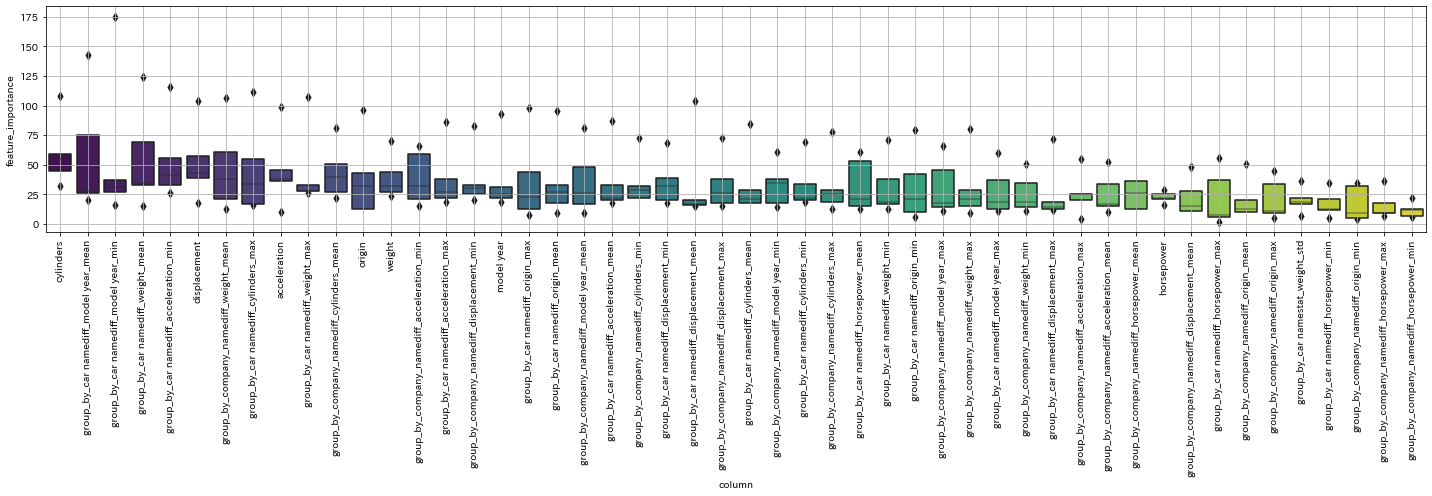

In [29]:
fig, ax = visualize_importance(models_lgbm, x)

In [30]:
y_pred_lgbm = np.array([model.predict(preprocessed_test_df.values) for model in models_lgbm])
y_pred_lgbm = np.mean(y_pred_lgbm, axis=0)

In [31]:
print(np.array([model.params for model in models_lgbm]))

[{'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.004802634342106974, 'lambda_l2': 1.8956484586708808e-07, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.8139913206643068, 'bagging_freq': 2, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 7, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 8.527697206896583, 'lambda_l2': 4.366611252804936, 'num_leaves': 96, 'feature_fraction': 1.0, 'bagging_fraction': 0.9585075943344723, 'bagging_freq': 5, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 1.3468762201907022e-05, 'lambda_l2': 0.00018141758532093654, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.43653283259079556, '

In [32]:
y_pred_lgbm

array([29.36117346, 27.81646521, 28.1385858 , 22.90281606, 30.61984058,
       26.98907153, 35.82259153, 23.63332618, 23.73789983, 22.48487098,
       27.91587962, 20.27038782, 30.00113706, 29.54173958, 17.7971766 ,
       17.67653609, 23.39249835, 34.14431245, 17.43777108, 36.33075502,
       17.83480097, 26.77211672, 23.50599031, 36.28840879, 28.47561978,
       22.89832404, 17.72748617, 18.10757764, 35.49846749, 36.29057188,
       28.22599471, 29.3681997 , 23.2382051 , 22.77914863, 17.50215391,
       35.7317207 , 34.90762624, 21.09659115, 30.5740093 , 42.47472365,
       27.18849203, 32.78383921, 22.47557899, 19.59451557, 28.1168403 ,
       36.25620083, 35.06168237, 27.70201348, 36.58534067, 29.36400253,
       22.87765426, 18.25622569, 23.33060533, 36.2763164 , 18.06659906,
       36.55391104, 23.30748117, 36.26673317, 17.61560196, 32.24740187,
       24.40086734, 26.7996399 , 23.19149086, 17.77757822, 36.57691116,
       31.09849176, 23.16782131, 35.59625524, 40.66112375, 22.86

In [33]:
print(sample_submission_df.shape)
sample_submission_df.head()

(800, 2)


,0,1
0,1200,0
1,1201,0
2,1202,0
3,1203,0
4,1204,0


In [34]:
len(y_pred_lgbm)

800

In [35]:
sample_submission_df[1] = y_pred_lgbm
sample_submission_df.head()

,0,1
0,1200,29.361173
1,1201,27.816465
2,1202,28.138586
3,1203,22.902816
4,1204,30.619841


In [36]:
sample_submission_df.to_csv(output_path + save_nm, index = False)